In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'medical-image-dataset-brain-tumor-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4327413%2F7435625%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T032705Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a5d376f69f59e0980bc78713450d39a73f755ac79ed023e5ac9465b3bbc270068832e3540c8c99649829c582e5ac8c74a5ba6303399a5382e3ef91ccfb5b1d3e365497250de7f737c4feb0acc46a465cd66f58270dd9a91c81bb78bb7b86434627204409359f8d65f980ba7f5e44fdb36c6732a9970b309d82f93230201e87d02c073bb27eb975c1083c69ce6647bb44f7f662835d592b1d47ebad9696337f36f05fd8e6438a11140d481646e63ebae5eaa3ed4b41a495b5ee06abf681d4723de879bbd99ae20c4a01580ba4ff660d462a95273c87fd143212bdf11f577ca5ab9eaaa93f65e4185d7f3c336b571b2737f14dfb20bca33d9ab04cbb2038d5149,yolov8/keras/yolo_v8_xs_backbone_coco/2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F4648%2F6105%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T032705Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D199efb5738aaf57c41c59fda9b8c204910ebb442803ce3464d227d130d4759802811f4b3922ad09cb85e9f73f35847fd893d471bfcbaa37ca9436b65438c6cbc8a521df1eb72b7e12c7449d4fda870947c4a6541c366fed9917d066591d405881026632c4e90a360bae3c37fce43416b5cdfde543cbfdbc5e3184a8c919c48b59f3ca2dcc1086e80d6b69863bd1de03c721eb1f9c1c0be687f337a6d10e3161ad429aeccc769175e28d5160bd543ff9feaefac72c3ebc40d049892a47c5c9af7b6db4bc88f9af86c06e1a3fcfc6ebddae6e1af6e9532baebb648913a1574bbf8df8c80451bdf2821ba648aa0e02b12d68aab67a5a27aae94b33657419dd3ac07'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 58291237 bytes downloaded
Downloaded and uncompressed: medical-image-dataset-brain-tumor-detection
[==================================================] 3091900 bytes downloaded
Downloaded and uncompressed: yolov8/keras/yolo_v8_xs_backbone_coco/2
Data source import complete.


In [ ]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

!pip install keras_cv
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> </span> Preprocessing

In [ ]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    v = int(img.shape[0])
    m = int(img.shape[1])

    fl_lbl = open(txt_path, "r")
    lns = fl_lbl.read().split('\n')

    bxs = []
    clss = []

    if lns[0] == '':
        return img_path, clss, bxs
    else:
        for i in range(0, int(len(lns))):
            objbd=lns[i].split(' ')
            cls_ = int(objbd[0])

            x1 = float(objbd[1])
            y1 = float(objbd[2])
            v1 = float(objbd[3])
            m1 = float(objbd[4])

            xmin = int((x1*v) - (v1*v)/2.0)
            ymin = int((y1*m) - (m1*m)/2.0)
            xmax = int((x1*v) + (v1*v)/2.0)
            ymax = int((y1*m) + (m1*m)/2.0)

            bxs.append([xmin ,ymin ,xmax ,ymax])
            clss.append(cls_)

    return img_path, clss, bxs


# a function for creating file paths list
def create_paths_list(path):
    fl_pth = []
    imgs = sorted(os.listdir(path))

    for i in imgs:
        fl_pth.append(os.path.join(path, i))

    return fl_pth


cls_ids = ['label0', 'label1']
cls_mpng = dict(zip(range(len(cls_ids)), cls_ids))

cls_mpng

{0: 'label0', 1: 'label1'}

In [ ]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_fls = create_paths_list(img_files_paths)
    ant_fls = create_paths_list(annot_files_paths)

    img_paths = []
    bbx = []
    clss = []

    for i in range(0,len(img_fls)):
        img_path_, clss_, bbx_ = parse_txt_annot(img_fls[i], ant_fls[i])
        img_paths.append(img_path_)
        bbx.append(bbx_)
        clss.append(clss_)

    img_paths = tf.ragged.constant(img_paths)
    bbx = tf.ragged.constant(bbx)
    clss = tf.ragged.constant(clss)

    return img_paths, clss, bbx

In [ ]:
# applying functions
trn_img_paths, trn_clss, trn_bbxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/train/images',
                                                              '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/train/labels')

vld_img_paths, vld_clss, vld_bbxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/images',
                                                              '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/labels')

tst_img_paths, tst_clss, tst_bbxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/test/images',
                                                            '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [ ]:
# reading and resizing images
def img_preprocessing(img_path):
    imge = tf.io.read_file(img_path)
    imge = tf.image.decode_jpeg(imge, channels = 3)
    imge = tf.cast(imge, tf.float32)

    return imge


reszng = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, clss, bbx):
    imge = img_preprocessing(img_paths)

    bndng_bxes = {
        "classes": tf.cast(clss, dtype=tf.float32),
        "boxes": bbx }

    return {"images": imge, "bounding_boxes": bndng_bxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [ ]:
# Creating dataset loaders and tf.datasets
trn_loader = tf.data.Dataset.from_tensor_slices((trn_img_paths, trn_clss, trn_bbxes))
trn_dtst = (trn_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(reszng, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


vld_loader = tf.data.Dataset.from_tensor_slices((vld_img_paths, vld_clss, vld_bbxes))
vld_dtst = (vld_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(reszng, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


tst_loader = tf.data.Dataset.from_tensor_slices((tst_img_paths, tst_clss, tst_bbxes))
tst_dtst = (tst_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(reszng, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [ ]:
# Print the shape of the training dataset
print("Training dataset shape:")
print("Number of images:", len(trn_img_paths))

# Print the shape of the validation dataset
print("\nValidation dataset shape:")
print("Number of images:", len(vld_img_paths))

# Print the shape of the test dataset
print("\nTest dataset shape:")
print("Number of images:", len(tst_img_paths))

Training dataset shape:
Number of images: 6930

Validation dataset shape:
Number of images: 1980

Test dataset shape:
Number of images: 990


In [ ]:
# a function to visualize samples from a dataset

def visualize_dataset(inpts, value_range, rows, cols, bounding_box_format):
    inpts = next(iter(inpts.take(1)))
    imgs, bounding_boxes = inpts[0], inpts[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        imgs,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=cls_mpng,
        true_color = (192, 57, 43))

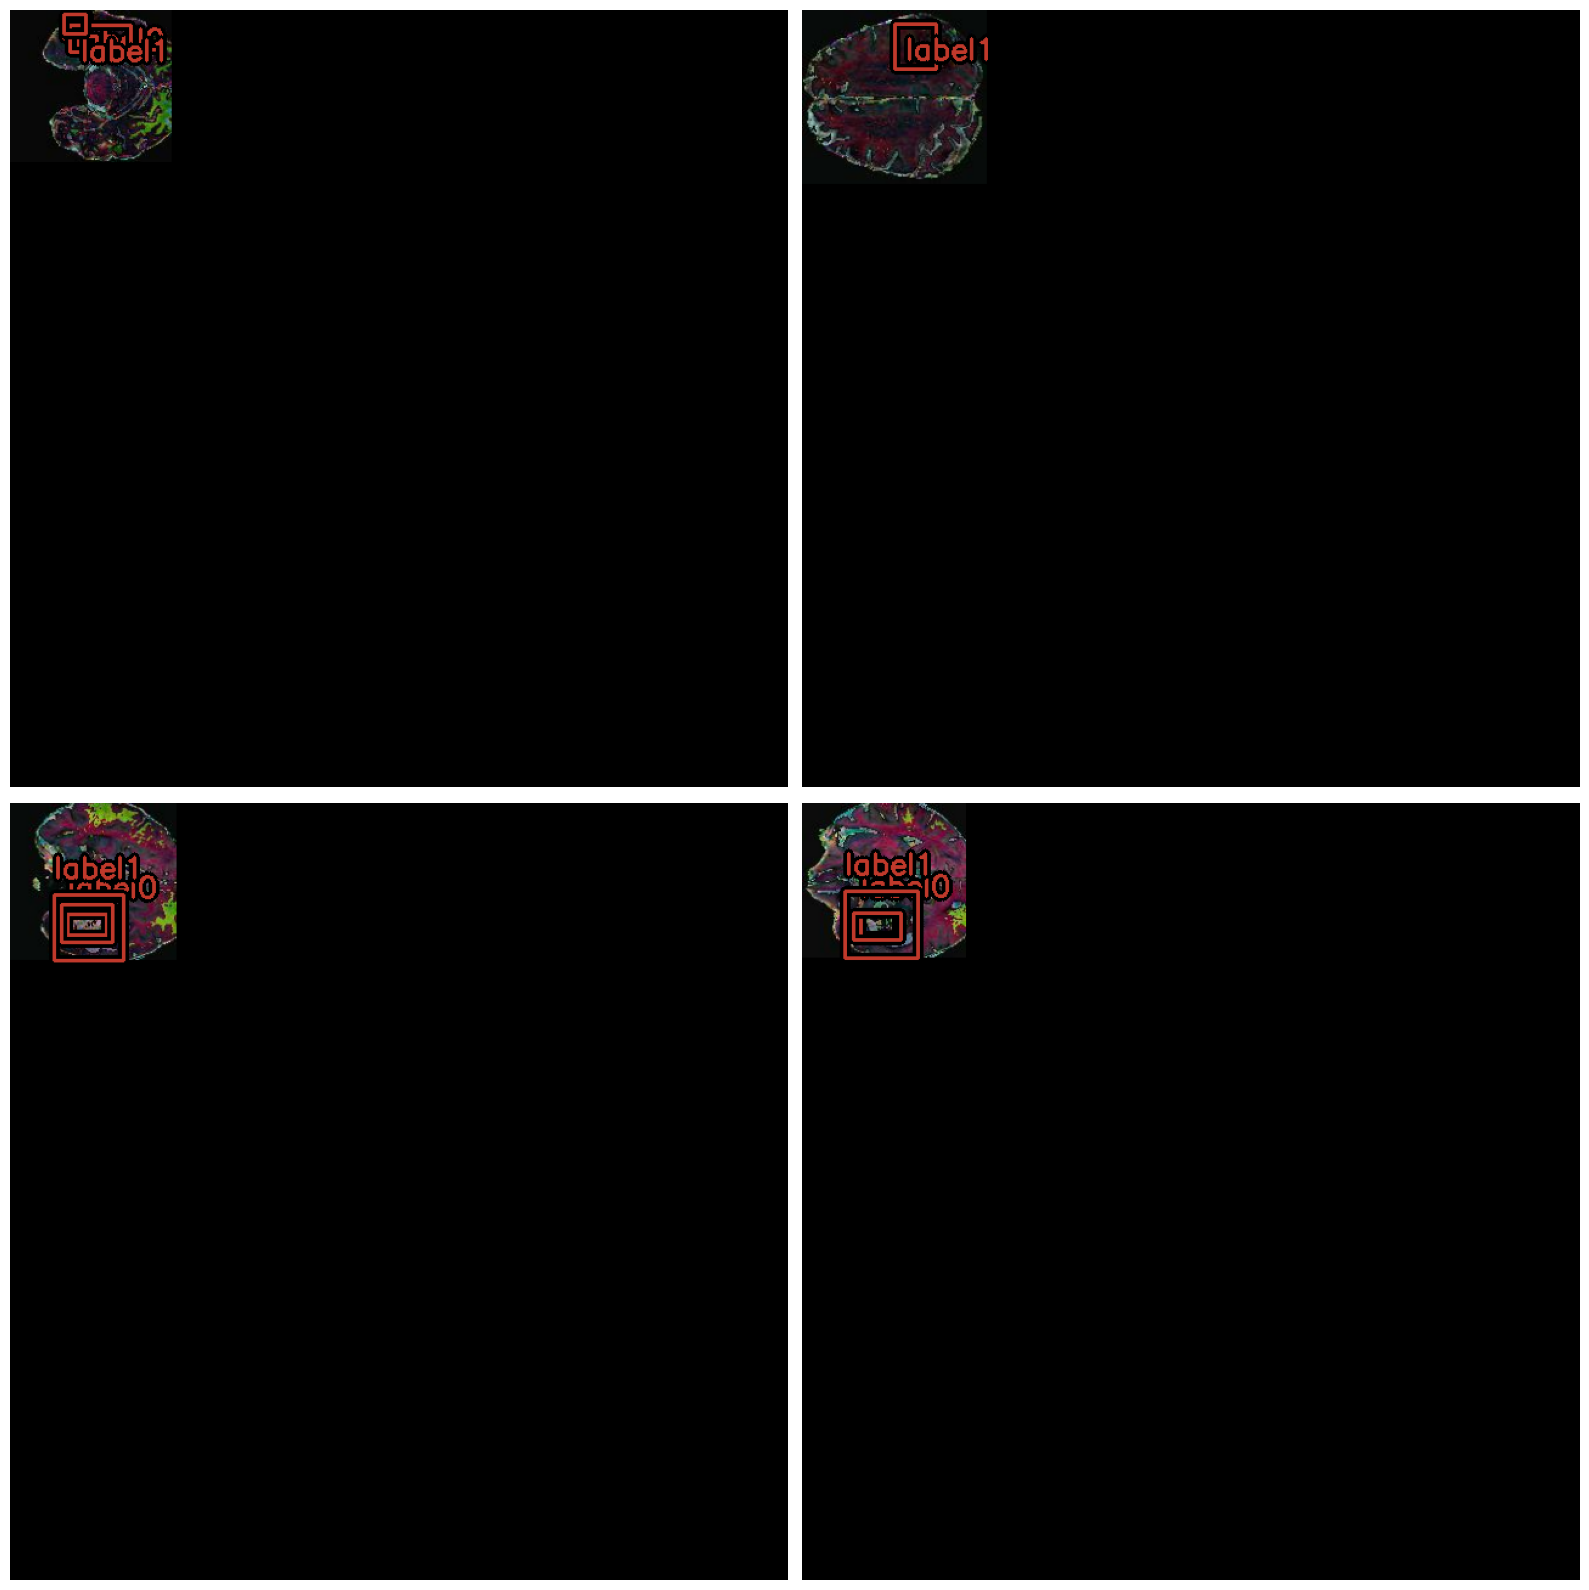

In [ ]:
# examples images and annotations from training daatset
visualize_dataset(trn_dtst, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> Hyperparameter Tuning and Model Building using YOLO V8and Keras CV(Random Search)</span>

Trial 1 Complete [00h 41m 31s]
val_loss: 3.1258065700531006

Best val_loss So Far: 3.1258065700531006
Total elapsed time: 00h 41m 31s
Best learning rate: 0.001
Best weight decay: 0.001
Epoch 1/10
1732/1732 [==============================] - 272s 133ms/step - loss: 61.9873 - box_loss: 2.9688 - class_loss: 59.0184 - val_loss: 4.5503 - val_box_loss: 2.9981 - val_class_loss: 1.5522
Epoch 2/10
1732/1732 [==============================] - 230s 133ms/step - loss: 3.7650 - box_loss: 2.6538 - class_loss: 1.1112 - val_loss: 5.7225 - val_box_loss: 2.7160 - val_class_loss: 3.0065
Epoch 3/10
1732/1732 [==============================] - 250s 144ms/step - loss: 3.4596 - box_loss: 2.4446 - class_loss: 1.0150 - val_loss: 4.7256 - val_box_loss: 2.6299 - val_class_loss: 2.0956
Epoch 4/10
1732/1732 [==============================] - 236s 136ms/step - loss: 3.2483 - box_loss: 2.3061 - class_loss: 0.9422 - val_loss: 3.6799 - val_box_loss: 2.4059 - val_class_loss: 1.2740
Epoch 5/10
1732/1732 [===============

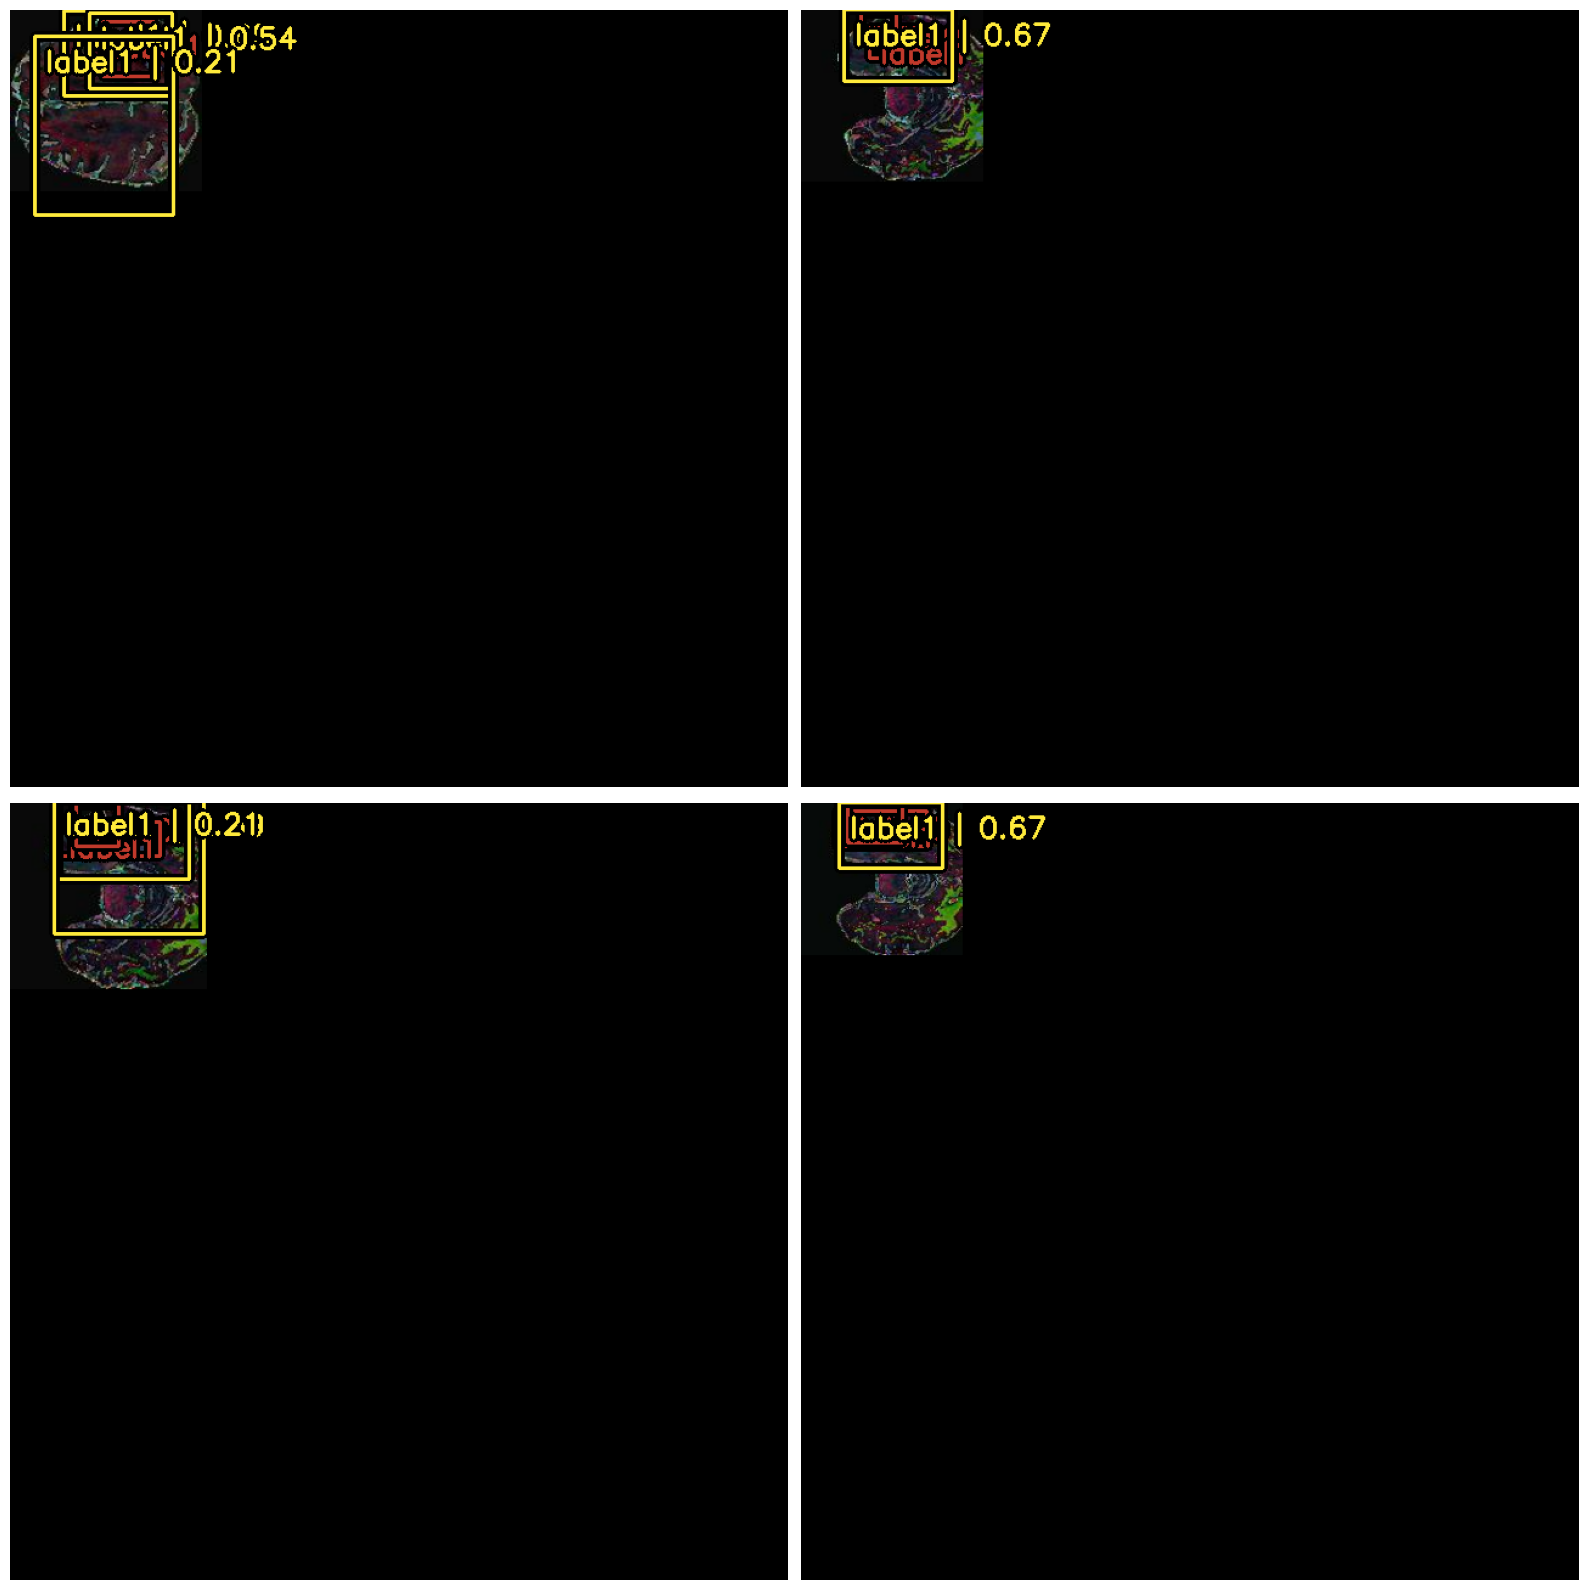

In [ ]:

!pip install keras-tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    bckbne = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")

    YOLOV8_model = keras_cv.models.YOLOV8Detector(
        num_classes=len(cls_mpng),
        bounding_box_format="xyxy",
        backbone=bckbne,
        fpn_depth=1
    )

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # Tune weight decay
    hp_weight_decay = hp.Choice('weight_decay', values=[1e-4, 5e-4, 1e-3])

    # Tune optimizer
    optimizer = AdamW(learning_rate=hp_learning_rate, weight_decay=hp_weight_decay, global_clipnorm=GLOBAL_CLIPNORM)

    YOLOV8_model.compile(
        optimizer=optimizer,
        classification_loss='binary_crossentropy',
        box_loss='ciou'
    )

    return YOLOV8_model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1 ,  # Adjust this based on computational resources and time available
    directory='hyperparameter_tuning',
    project_name='yolov8_tuning'
)

tuner.search(trn_dtst,
             validation_data=vld_dtst,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight decay: {best_hps.get('weight_decay')}")

# Build the model with the optimal hyperparameters
YOLOV8_model = tuner.hypermodel.build(best_hps)

# Train the model
hist = YOLOV8_model.fit(trn_dtst, validation_data=vld_dtst, epochs=10),

def visualize_predict_detections(model, dataset, bounding_box_format):
    imgs, y_true = next(iter(dataset.take(1)))

    y_prd = model.predict(imgs)
    y_prd = keras_cv.bounding_box.to_ragged(y_prd)

    keras_cv.visualization.plot_bounding_box_gallery(
        imgs,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_prd,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=cls_mpng,
    )

# Visualize predictions
visualize_predict_detections(YOLOV8_model, dataset=tst_dtst, bounding_box_format="xyxy")
